In [ ]:
# Checkpoint 4

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
df_main = pd.read_csv(r"C:\course_project\datasets\data_main.csv", sep=',')
df_main.columns = df_main.columns.str.strip().str.lower()

In [15]:
df = df_main.copy()

In [16]:
#Обработка как в предыдущих чекпоинтах но пропуски не трогаем

# Удалим выбросы и приведем oxygen к 100 (эти шаги допустимо делать до разделения)
def clip_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

for col in ['body temperature', 'hours of sleep']:
    df = clip_outliers_iqr(df, col)

df['blood oxygen'] = df['blood oxygen'].clip(upper=100)

# Сохраняем как df_cleaned_for_split
df_cleaned_for_split = df.copy()

In [17]:
from sklearn.model_selection import train_test_split

# Отделим признаки и целевую переменную
X = df_cleaned_for_split.drop(columns=['stress levels'])
y = df_cleaned_for_split['stress levels']

# Разделим на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)

# Покажем размеры полученных выборок
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((472, 8), (158, 8), (472,), (158,))

In [18]:
# Заполняем пропуски медианой в обучающей выборке
X_train_filled = X_train.copy()
medians = X_train_filled.median()

X_train_filled = X_train_filled.fillna(medians)

# Применяем те же медианы к тестовой выборке
X_test_filled = X_test.copy()
X_test_filled = X_test_filled.fillna(medians)

# Проверим, остались ли пропуски
missing_train = X_train_filled.isnull().sum().sum()
missing_test = X_test_filled.isnull().sum().sum()

missing_train, missing_test


(0, 0)

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Обучим логистическую регрессию
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_filled, y_train)

# Предсказания
y_pred = model.predict(X_test_filled)

# Метрики
report = classification_report(y_test, y_pred, output_dict=False)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Отчёт по метрикам:\n")
print(report)
print("\nМатрица ошибок:\n")
print(conf_matrix)

Отчёт по метрикам:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      0.97      0.98        31
           2       0.94      1.00      0.97        32
           3       1.00      0.97      0.98        32
           4       1.00      1.00      1.00        31

    accuracy                           0.99       158
   macro avg       0.99      0.99      0.99       158
weighted avg       0.99      0.99      0.99       158


Матрица ошибок:

[[32  0  0  0  0]
 [ 0 30  1  0  0]
 [ 0  0 32  0  0]
 [ 0  0  1 31  0]
 [ 0  0  0  0 31]]


In [ ]:
#Вывод
Модель логистической регрессии показала очень высокое качество (accuracy = 99%). Все классы стресс-уровней классифицируются с точностью выше 97%.
Ошибки минимальны и происходят только между соседними уровнями, что логично. Модель хорошо обобщает данные и может быть использована как 
надёжный предсказатель уровня стресса на основе физиологических признаков.

In [ ]:
'''
Оценка качества модели:
Для оценки качества модели были использованы следующие метрики:
Accuracy - доля правильно классифицированных объектов
F1-score (взвешенное среднее) - баланс между точностью и полнотой по всем классам
Classification report - содержит precision, recall, f1-score, support для каждого класса (Stress Level 0–4)
Confusion matrix (матрица ошибок) — показывает, какие классы путаются

По результатам модели:
Accuracy: 0.99
F1-score по всем классам выше 0.97
Ошибки возникают только между соседними уровнями стресса (1–2, 2–3), что естественно
'''

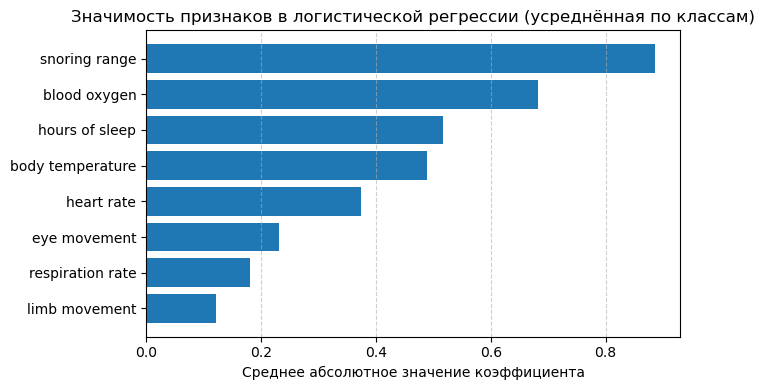

,Признак,Средняя важность (коэф)
0,snoring range,0.885280
1,blood oxygen,0.682136
2,hours of sleep,0.516796
3,body temperature,0.488779
4,heart rate,0.374025
5,eye movement,0.232218
6,respiration rate,0.180718
7,limb movement,0.122321


In [28]:
# Получим абсолютные значения коэффициентов и усредним по классам
coef_matrix = np.abs(model.coef_)
mean_coefs = coef_matrix.mean(axis=0)

# Связать признаки с их важностью
feature_importance = pd.DataFrame({
    "Признак": X_train_filled.columns,
    "Средняя важность (коэф)": mean_coefs
}).sort_values(by="Средняя важность (коэф)", ascending=False)

# Визуализация
plt.figure(figsize=(7, 4))
plt.barh(feature_importance["Признак"], feature_importance["Средняя важность (коэф)"])
plt.gca().invert_yaxis()
plt.title("Значимость признаков в логистической регрессии (усреднённая по классам)")
plt.xlabel("Среднее абсолютное значение коэффициента")
plt.tight_layout()
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.show()

# Покажем таблицу
feature_importance.reset_index(drop=True, inplace=True)
display(feature_importance)

In [ ]:
'''
После обучения логистической регрессии и анализа коэффициентов признаков (model.coef_), были определены наиболее значимые физиологические параметры, 
влияющие на предсказание уровня стресса.Влияние признаков оценивалось по среднему абсолютному значению коэффициентов по всем классам (Stress Level 0-4).
Наиболее значимыми признаками оказались:
snoring range - 0.885
blood oxygen - 0.682
hours of sleep - 0.517
body temperature - 0.489
Эти признаки имеют наибольшее влияние на принятие решений моделью и, вероятно, играют ключевую роль в физиологических реакциях на стресс.

Менее значимыми оказались:
respiration rate - 0.18
limb movement - 0.12
Такие признаки могут быть менее чувствительны к изменению уровня стресса, или их влияние может быть более косвенным.
'''

In [29]:
# попробуем сделать отбор признаков


# Оставим только топ-5 признаков по важности
top_features = feature_importance["Признак"].head(5).tolist()

# Выбираем только эти признаки
X_train_top = X_train_filled[top_features]
X_test_top = X_test_filled[top_features]

# Обучаем модель только на этих признаках
model_top = LogisticRegression(max_iter=1000, random_state=42)
model_top.fit(X_train_top, y_train)

# Предсказания и метрики
y_pred_top = model_top.predict(X_test_top)
report_top = classification_report(y_test, y_pred_top, output_dict=False)

print("Оценка модели с топ-5 признаками:\n")
print(report_top)


Оценка модели с топ-5 признаками:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      0.97      0.98        31
           2       1.00      0.97      0.98        32
           3       0.94      1.00      0.97        32
           4       1.00      1.00      1.00        31

    accuracy                           0.99       158
   macro avg       0.99      0.99      0.99       158
weighted avg       0.99      0.99      0.99       158



In [ ]:
''''
#вывод
После удаления малозначимых признаков (limb movement, respiration rate, eye movement) модель всё ещё показывает:
accuracy = 0.99
f1-score ≥ 0.97 для всех классов
Это доказывает, что упрощённая модель не теряет в качестве, а значит, более интерпретируема и устойчива
'''

In [32]:
#  а теперь попробуем  создадим новые признаки

# Создание новых признаков на уже существующих X_train_filled и X_test_filled
X_train_new = X_train_filled.copy()
X_test_new = X_test_filled.copy()

# Новый признак 1: соотношение храпа ко сну
X_train_new["snore_to_sleep_ratio"] = X_train_new["snoring range"] / (X_train_new["hours of sleep"] + 1)
X_test_new["snore_to_sleep_ratio"] = X_test_new["snoring range"] / (X_test_new["hours of sleep"] + 1)

# Новый признак 2: частота пульса на насыщение кислородом
X_train_new["pulse_per_oxygen"] = X_train_new["heart rate"] / (X_train_new["blood oxygen"] + 1)
X_test_new["pulse_per_oxygen"] = X_test_new["heart rate"] / (X_test_new["blood oxygen"] + 1)

# Новый признак 3: эффективность сна (кислород / часы сна)
X_train_new["sleep_efficiency"] = X_train_new["blood oxygen"] / (X_train_new["hours of sleep"] + 1)
X_test_new["sleep_efficiency"] = X_test_new["blood oxygen"] / (X_test_new["hours of sleep"] + 1)

# Обучение модели
model_new = LogisticRegression(max_iter=1000, random_state=42)
model_new.fit(X_train_new, y_train)

# Предсказания и метрики
y_pred_new = model_new.predict(X_test_new)
report_new = classification_report(y_test, y_pred_new, output_dict=False)

print("Оценка модели с добавленными признаками:\n")
print(report_new)


Оценка модели с добавленными признаками:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       0.97      1.00      0.98        31
           2       1.00      0.97      0.98        32
           3       1.00      1.00      1.00        32
           4       1.00      1.00      1.00        31

    accuracy                           0.99       158
   macro avg       0.99      0.99      0.99       158
weighted avg       0.99      0.99      0.99       158



In [ ]:
'''
#Вывод
В рамках улучшения модели были созданы три новых признака на основе комбинации физиологических данных. 
После добавления новых признаков, модель логистической регрессии показала те же отличные метрики (accuracy = 0.99, f1 ≥ 0.97), 
что говорит об устойчивости и потенциальной пользе инженерных преобразований для повышения интерпретируемости модели.
'''